In [1]:
import pandas as pd
import numpy as np
import boto3
from pathlib import Path
import glob
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from LFP_util import data_manage as dm

In [3]:
ANIMALS = ['CAF37', 'CAF78', 'KDR14', 'KDR27', 'KDR36', 'CAF62']
PRED_DIR = './data/CNN_Pred/'
FLICKER_DIR = './data/Flicker_data/'

def get_s3_client():
    with open(f"{Path.home()}/.aws/credentials", "r") as f:
        for line in f:
            if "aws_access_key_id" in line:
                id = re.search(r"\W(\w+)", line).group(1)
            if "aws_secret_access_key" in line:
                key = re.search(r"\W(\w+)", line).group(1)
        return boto3.Session(aws_access_key_id=id, aws_secret_access_key=key).client(
            "s3", endpoint_url="https://s3-central.nrp-nautilus.io"
        )

def get_predictions(animal, client):
    all_objects = client.list_objects_v2(
        Bucket = 'hengenlab',
        Prefix = f'{animal}_day1/Runs/'
    )['Contents']
    flatten_objects = [o['Key'] for o in all_objects]
    return [object for object in flatten_objects if 'predictions' in object]

def get_flickers(animal, client):
    all_objects = client.list_objects_v2(
        Bucket = 'hengenlab',
        Prefix = f'{animal}_day1/flicker-calling'
    )['Contents']
    flatten_objects = [o['Key'] for o in all_objects]
    return [object for object in flatten_objects if 'flicker' in object and 'transitions' not in object]



## Evaluate CNN predictions

In [4]:
# Get CNN prediction

client = get_s3_client()
for animal in ANIMALS:
    preds = get_predictions(animal, client)
    for ind, pred in enumerate(preds):
        print(f'Getting file {pred}')
        client.download_file('hengenlab', pred, f'./data/CNN_Pred/{animal}_run{ind}.csv.zip')

Getting file CAF37_day1/Runs/wnr-v14-perregion-c24k-0-64-run1/Results/predictions_CAF37_day1.csv.zip
Getting file CAF37_day1/Runs/wnr-v14-perregion-c24k-0-64-run2/Results/predictions_CAF37_day1.csv.zip
Getting file CAF37_day1/Runs/wnr-v14-perregion-c24k-0-64-run3/Results/predictions_CAF37_day1.csv.zip
Getting file CAF78_day1/Runs/wnr-v14-perregion-c24k-0-64-run1/Results/predictions_CAF78_day1.csv.zip
Getting file CAF78_day1/Runs/wnr-v14-perregion-c24k-0-64-run2/Results/predictions_CAF78_day1.csv.zip
Getting file CAF78_day1/Runs/wnr-v14-perregion-c24k-0-64-run3/Results/predictions_CAF78_day1.csv.zip
Getting file KDR14_day1/Runs/wnr-v14-perregion-c24k-0-64-run1/Results/predictions_KDR14_day1.csv.zip
Getting file KDR14_day1/Runs/wnr-v14-perregion-c24k-0-64-run2/Results/predictions_KDR14_day1.csv.zip
Getting file KDR14_day1/Runs/wnr-v14-perregion-c24k-0-64-run3/Results/predictions_KDR14_day1.csv.zip
Getting file KDR27_day1/Runs/wnr-v14-perregion-c24k-0-64-run1/Results/predictions_KDR27_day

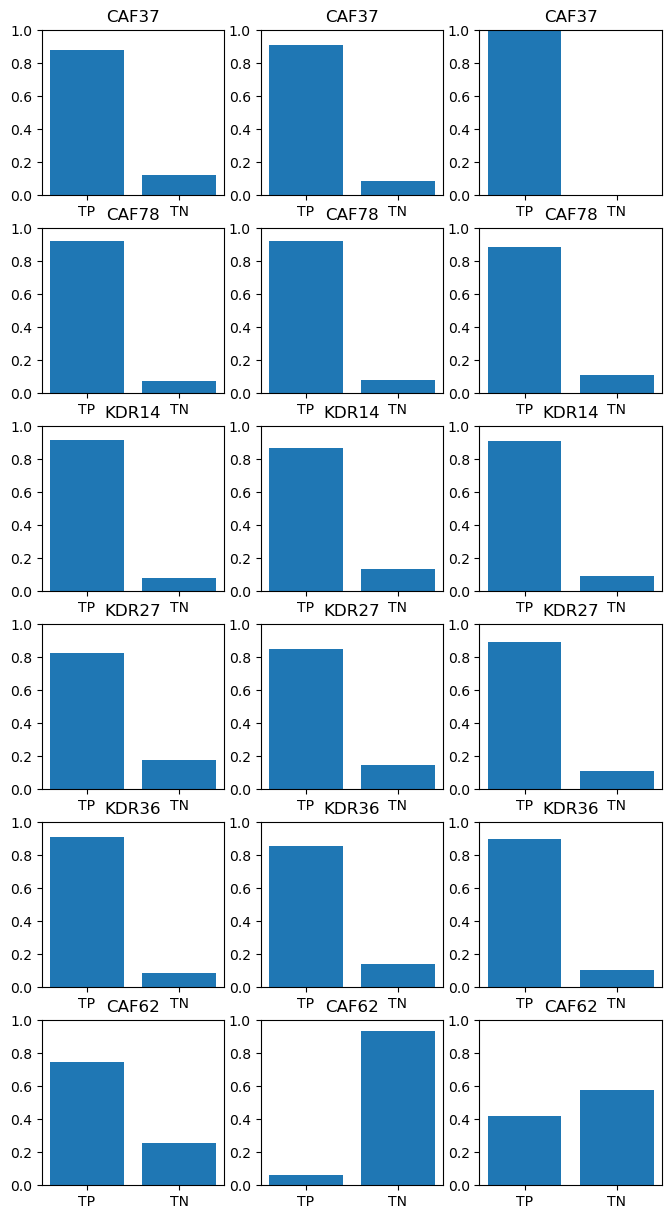

In [37]:
fig, axs = plt.subplots(len(ANIMALS),3,figsize=(8,15))
for i, animal in enumerate(ANIMALS):
    selection_animal = pd.concat(
        [pd.read_csv(f) for f in glob.glob(f'./data/CNN_Pred/*{animal}*')]
    )
    for j in range(3):
        selection = selection_animal[selection_animal['label_wnr_012'] == j]
        axs[i,j].bar(
            ['TP', 'TN'],
            ((selection['label_wnr_012'] == selection['predicted_wnr_012']).mean(),
            (selection['label_wnr_012'] != selection['predicted_wnr_012']).mean())
        )
        axs[i,j].set_ylim(0, 1)
        axs[i,j].title.set_text(animal)

In [41]:
pd.read_csv(glob.glob('./data/CNN_Pred/CAF62_run0.csv.zip')[0]).predicted_wnr_012

0          2
1          2
2          1
3          2
4          2
          ..
1187958    0
1187959    0
1187960    0
1187961    0
1187962    0
Name: predicted_wnr_012, Length: 1187963, dtype: int64

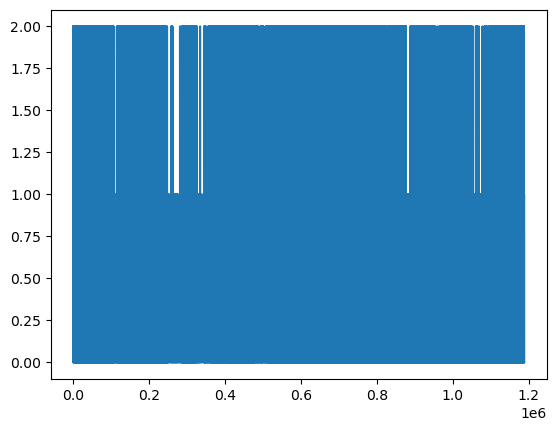

In [42]:
plt.plot(
    range(len(Out[41])),
    Out[41]
)

## Extract Flickers

In [5]:
# Download flicker files

for animal in ANIMALS:
    preds = get_flickers(animal, client)
    for ind, pred in enumerate(preds):
        print(f'Getting file {pred}')
        client.download_file('hengenlab', pred, f'./data/Flicker_data/{animal}_run{ind}.csv.zip')

flicker_files = glob.glob(FLICKER_DIR + '*')

Getting file CAF37_day1/flicker-calling/Results/flicker-calling-narrownone-CAF37_day1-wnr-v14-perregion-c24k.csv.zip
Getting file CAF78_day1/flicker-calling/Results/flicker-calling-narrownone-CAF78_day1-wnr-v14-perregion-c24k.csv.zip
Getting file KDR14_day1/flicker-calling/Results/flicker-calling-narrownone-KDR14_day1-wnr-v14-perregion-c24k.csv.zip
Getting file KDR27_day1/flicker-calling/Results/flicker-calling-narrownone-KDR27_day1-wnr-v14-perregion-c24k.csv.zip
Getting file KDR36_day1/flicker-calling/Results/flicker-calling-narrownone-KDR36_day1-wnr-v14-perregion-c24k.csv.zip


In [126]:
def compute_hourly_rate(df):
    result = {
        'Hour': [],
        'None': [],
        '0-1': [],
        '0-2': [],
        '1-0': [],
        '1-2': [],
        '2-0': [],
        '2-1': [],
    }

    i = 0
    while i + 15*3600 < df.shape[0]:
        df_clip = df.iloc[i:i+15*3600]
        rates = df_clip.groupby(df_clip).count()
        for type in ['None','0-1','0-2','1-0','1-2','2-0','2-1']:
            result[type].append(rates[type] if type in rates.index.array else 0)
        result['Hour'].append(i // (15*3600))
        i += 15*3600
    temp = pd.DataFrame(result)
    return temp

def compute_rate_by_bout(flicker, raw):
    result = {
        'Type': [],
        'Rate(per sec)': []
    }

    raw = raw['label_wnr_012']
    df = np.append(['<s>'], raw)
    state_changes = np.append(np.where(df[:-1] != df[1:])[0][:-1], [raw.shape[0]])

    for start_1, start_2 in zip(state_changes[:-1], state_changes[1:]):
        clip = flicker[start_1 : start_2]
        for type in clip.unique():
            result['Rate(per sec)'].append((clip == type).mean())
            result['Type'].append(type)
    
    return pd.DataFrame(result)

In [127]:
dfs = []
for file in glob.glob(FLICKER_DIR + '*'):
    f1 = pd.read_csv(file)
    state = f1[['CA1-0-64-flicker-state', 'CA1-0-64-surrounding-state']].apply(lambda x: f"{x[0]}-{x[1]}" if x[0] != -1 else 'None', axis=1)
    tempd = compute_rate_by_bout(state, f1)
    animal = re.search(r'(CAF|KDR)\d+', file).group()
    tempd['Animal'] = animal
    dfs.append(tempd)

all_rates = pd.concat(dfs)

In [128]:
all_rates_geno = all_rates.set_index('Animal').join(dm.agg('Animal')['Genotype'])

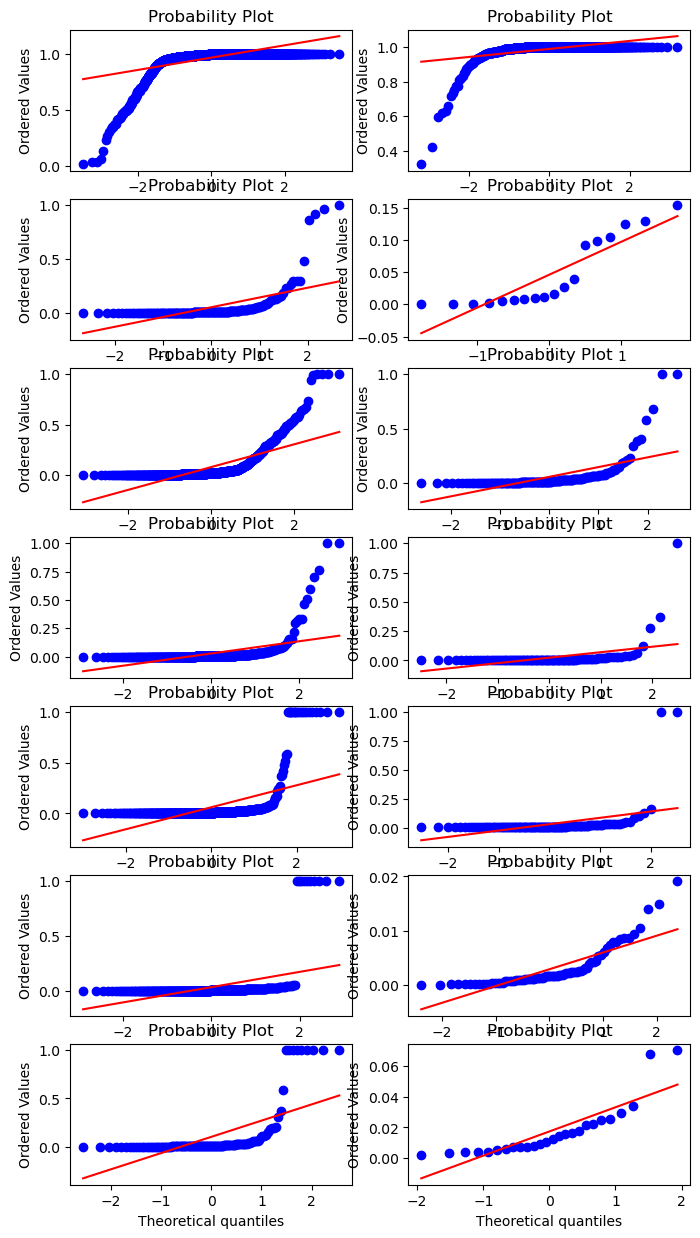

In [130]:
fig, axs = plt.subplots(7, 2, figsize=(8, 15))
for i, t in enumerate(('WT','TE4')):
    for j, s in enumerate(all_rates.Type.unique()):
        stats.probplot(
            all_rates_geno[(all_rates_geno.Genotype == t) & (all_rates_geno.Type == s)]['Rate(per sec)'],
            dist="norm", plot=axs[j, i]
        );

<Axes: xlabel='Genotype', ylabel='Rate(per sec)'>

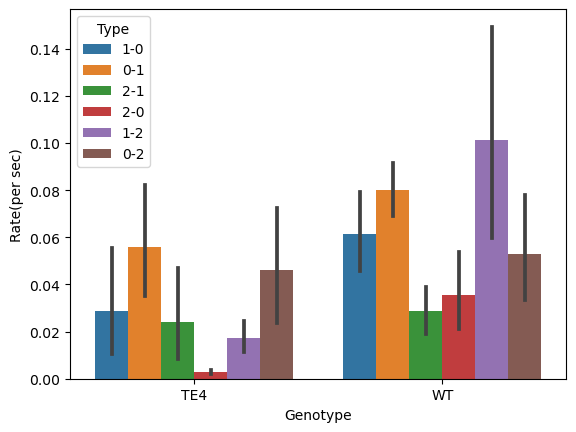

In [135]:
sns.barplot(
    data = all_rates_geno[all_rates_geno['Type'] != 'None'],
    x = 'Genotype',
    y = 'Rate(per sec)',
    hue = 'Type'
)

<Axes: xlabel='Animal', ylabel='Rate(per sec)'>

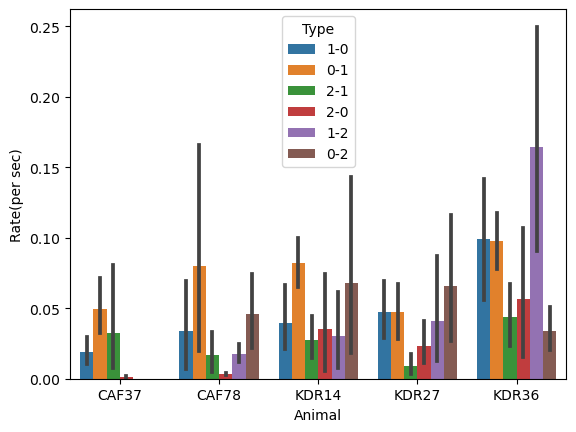

In [139]:
sns.barplot(
    data = all_rates_geno[all_rates_geno['Type'] != 'None'].reset_index(),
    x = 'Animal',
    y = 'Rate(per sec)',
    hue = 'Type'
)

In [140]:
for type in all_rates_geno.Type.unique():
    clip = all_rates_geno[all_rates_geno.Type == type]
    print(f'Testing {type}')
    print(
        stats.ranksums(
            clip[clip.Genotype == 'WT']['Rate(per sec)'],
            clip[clip.Genotype == 'TE4']['Rate(per sec)']
        )
    )

Testing None
RanksumsResult(statistic=-9.470807574653103, pvalue=2.776884179863426e-21)
Testing 1-0
RanksumsResult(statistic=3.8420183188550503, pvalue=0.00012202672625747576)
Testing 0-1
RanksumsResult(statistic=3.386239366835873, pvalue=0.0007085754842894649)
Testing 2-1
RanksumsResult(statistic=2.119537774568039, pvalue=0.03404504489296776)
Testing 2-0
RanksumsResult(statistic=6.296460805845544, pvalue=3.045182315059293e-10)
Testing 1-2
RanksumsResult(statistic=-0.7578204601898798, pvalue=0.44855847207036903)
Testing 0-2
RanksumsResult(statistic=-1.2140378667408849, pvalue=0.22473326452262465)


Todo:
- Use model of CAF78 to make more predictions using rest of the data
- New model for CAF62